In [32]:
# Libraries
import numpy as np
import math
from scipy.linalg import block_diag
from matplotlib import pyplot as plt
import copy
%matplotlib widget
plt.rcParams['figure.figsize']=[10,10]

In [4]:
# Transformation rules for adjacency matrix, Z

def transform_Z(symplectic, Z):
    A = symplectic[:int(np.shape(symplectic)[0]/2),:int(np.shape(symplectic)[0]/2)]
    B = symplectic[int(np.shape(symplectic)[0]/2):,:int(np.shape(symplectic)[0]/2)]
    C = symplectic[:int(np.shape(symplectic)[0]/2),int(np.shape(symplectic)[0]/2):]
    D = symplectic[int(np.shape(symplectic)[0]/2):,int(np.shape(symplectic)[0]/2):]

    return (C + D@Z)@np.linalg.inv(A + B@Z)

# Mode transformation from H-graph into Approximate CV Cluster state

def identify_bipartition(Z):
    modes = list(np.arange(int(np.shape(Z)[0])))
    for mode in modes:
        test_modes = copy.deepcopy(modes)
        test_modes.remove(mode)
        for test_mode in test_modes:
            if abs(Z[mode][test_mode]) > 0.1 or abs(Z[test_mode][mode]) > 0.1: #MAY NEED TO LOWER THESE LIMITS FOR LOW SQUEEZING
                modes.remove(test_mode)
    return modes

def generate_S_h2c(modes):
    S_h2c = np.identity(num_modes*4)
    for mode in modes:
        S_h2c[mode][mode] = 0
        S_h2c[mode][mode+2*num_modes] = -1
        S_h2c[mode+2*num_modes][mode] = 1
        S_h2c[mode+2*num_modes][mode+2*num_modes] = 0

    return S_h2c

# Symplectic matrix for EPR state generation from two initially squeezed modes

def epr_symplectic():

    #Delay on B mode

    S_phase_delay = np.zeros((num_modes*4, num_modes*4))

    for i in range(num_modes):
        S_phase_delay[i*2,i*2] = 1
        S_phase_delay[(num_modes+i)*2,(num_modes+i)*2] = 1
        S_phase_delay[i*2+1,(num_modes+i)*2+1] = -1
        S_phase_delay[(num_modes+i)*2+1,i*2+1] = 1

    #Beamsplitter for EPR state generation

    S_bs0 = np.array([])

    for i in range(num_modes):
        bs_block = np.array([[1/np.sqrt(2),-1/np.sqrt(2)],[1/np.sqrt(2),1/np.sqrt(2)]])
        if i == 0:
            S_bs0 = np.block([
                [bs_block, np.zeros((2,2))],
                [np.zeros((2,2)), bs_block]
            ])
        else:
            size = np.shape(S_bs0)
            S_bs0 = np.block([
                [S_bs0[:int(size[0]/2),:int(size[0]/2)],np.zeros((int(size[1]/2),2)), S_bs0[int(size[0]/2):,:int(size[0]/2)],np.zeros((int(size[1]/2),2))],
                [np.zeros((2,int(size[0]/2))), bs_block, np.zeros((2,int(size[0]/2))), np.zeros((2,2))],
                [S_bs0[int(size[0]/2):,:int(size[0]/2)], np.zeros((int(size[1]/2),2)), S_bs0[int(size[0]/2):,int(size[0]/2):], np.zeros((int(size[1]/2),2))],
                [np.zeros((2,int(size[0]/2))), np.zeros((2,2)), np.zeros((2,int(size[0]/2))), bs_block]
            ])

    return S_bs0@S_phase_delay

# Symplectic matrix for cluster state generation from an EPR state

def cluster_symplectic(bs_1=0, bs_2=0, bs_3=0):

    #Beamsplitter for 1D cluster generation

    if bs_1 == 0:

        S_bs1 = np.diag(np.ones(num_modes*4))

    else:

        bs1_block = np.diag(np.ones(num_modes*2))

        for i in range(num_modes):
            if 2*i+1+(2*bs_1-1) < num_modes*2:
                bs1_block[2*i+1,2*i+1] = 1/np.sqrt(2)
                bs1_block[2*i+1,2*i+1+(2*bs_1-1)] = -1/np.sqrt(2)
                bs1_block[2*i+1+(2*bs_1-1),2*i+1] = 1/np.sqrt(2)
                bs1_block[2*i+1+(2*bs_1-1),2*i+1+(2*bs_1-1)] = 1/np.sqrt(2)

        S_bs1 = np.block([[bs1_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs1_block]]) 

    #Beamsplitter for 2D cluster generation

    if bs_2 == 0:

        S_bs2 = np.diag(np.ones(num_modes*4))

    else:

        bs2_block = np.diag(np.ones(num_modes*2))

        for i in range(num_modes):
            if 2*i+1+(2*bs_2-1) < num_modes*2:
                bs2_block[2*i+1,2*i+1] = 1/np.sqrt(2)
                bs2_block[2*i+1,2*i+1+(2*bs_2-1)] = -1/np.sqrt(2)
                bs2_block[2*i+1+(2*bs_2-1),2*i+1] = 1/np.sqrt(2)
                bs2_block[2*i+1+(2*bs_2-1),2*i+1+(2*bs_2-1)] = 1/np.sqrt(2)

        S_bs2 = np.block([[bs2_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs2_block]])  

    #Beamsplitter for 3D cluster generation

    if bs_3 == 0:

        S_bs3 = np.diag(np.ones(num_modes*4))
    
    else:

        bs3_block = np.diag(np.ones(num_modes*2))

        for i in range(num_modes):
            if 2*i+1+(2*bs_3-1) < num_modes*2:
                bs3_block[2*i+1,2*i+1] = 1/np.sqrt(2)
                bs3_block[2*i+1,2*i+1+(2*bs_3-1)] = -1/np.sqrt(2)
                bs3_block[2*i+1+(2*bs_3-1),2*i+1] = 1/np.sqrt(2)
                bs3_block[2*i+1+(2*bs_3-1),2*i+1+(2*bs_3-1)] = 1/np.sqrt(2)

        S_bs3 = np.block([[bs3_block, np.zeros((num_modes*2, num_modes*2))],[np.zeros((num_modes*2, num_modes*2)), bs3_block]]) 

    return S_bs3@S_bs2@S_bs1

def measure_nodes(nodes, Z):
    for node in nodes:
        for i in range(np.shape(Z)[0]):
            Z[node][i] = 0
            Z[i][node] = 0

    return Z

def rotate_node(node, angle, Z):
    
    S_rot = np.diag(np.ones(num_modes*4))
    S_rot[mode][mode] = np.cos(angle)
    S_rot[mode+2*num_modes][mode+2*num_modes] = np.cos(angle)
    S_rot[mode][mode+2*num_modes] = np.sin(angle)
    S_rot[mode+2*num_modes][mode] = -np.sin(angle)

    return  transform_Z(S_rot, Z)

def round_matrix(M):
    rounded_M = np.zeros(np.shape(M))
    for i in range(np.shape(M)[0]):
        for j in range(np.shape(M)[1]):
            rounded_M[i][j] = round(100*np.real(M[i][j]))/100

    return rounded_M

# 1D Single Mode Gates

In [18]:
r_vals = np.linspace(0.1,10,100)

noise = []

for r in r_vals:

    num_modes = 1

    bs_1 = 1

    Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

    Z = transform_Z(epr_symplectic(), Z)

    bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

    S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

    Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

    A = np.block([[np.array([0]), np.zeros((1,np.shape(Z)[0]))],[np.zeros((np.shape(Z)[0],1)),Z]])

    S_cz = np.block([
        [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
        [A, np.identity(np.shape(A)[0])]
    ])

    B = np.identity(np.shape(A)[0])
    B[0][0] = 1/np.sqrt(2)
    B[1][1] = 1/np.sqrt(2)
    B[0][1] = -1/np.sqrt(2)
    B[1][0] = 1/np.sqrt(2)

    S_bs = np.block([
        [B, np.zeros(np.shape(B))],
        [np.zeros(np.shape(B)), B]
    ])

    c = np.zeros(np.shape(A))
    s = np.zeros(np.shape(A))

    ################################################################################################################

    t = np.tanh(2*r)

    c[0][0]=np.cos(-np.arctan(1/t))
    c[1][1]=np.cos(np.arctan(1/t))

    s[0][0]=np.sin(-np.arctan(1/t))
    s[1][1]=np.sin(np.arctan(1/t))


    ################################################################################################################

    c[2][2]=1

    S_r = np.block([
        [c, s],
        [-s, c]
    ])

    S = S_r@S_bs@S_cz

    U = np.vstack([
        S[0:2,1:3]
    ])

    V = np.hstack((np.atleast_2d(S[0:2,0]).T,S[0:2,3:6]))

    Z = np.block([
        [S[2,0],S[2,3:6]],
        [S[5,0],S[5,3:6]]
    ])

    Y = np.vstack([
        S[2,1:3],
        S[5,1:3]
    ])

    M = Z - Y@np.linalg.inv(U)@V

    gate_noise = []
    for i in range(np.shape(M)[0]):
        noise_temp = 0
        for j in range(np.shape(M)[0],np.shape(M)[1]):
            noise_temp += M[i][j]**2
        gate_noise.append(noise_temp)

    noise.append(max(gate_noise))

/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


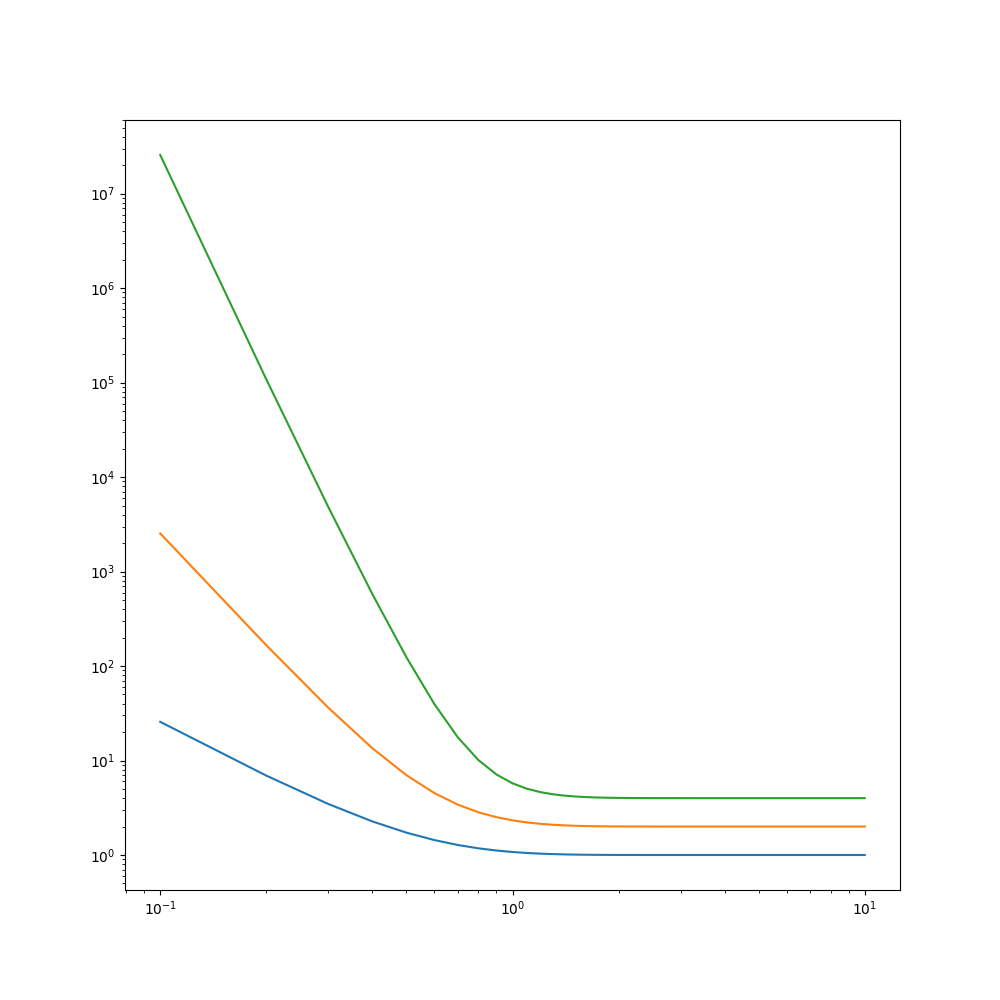

In [33]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(r_vals, noise)
ax.plot(r_vals, noise_2d)
ax.plot(r_vals, noise_3d)
ax.set_yscale('log')
ax.set_xscale('log')

# 2D Single Mode Gates

In [24]:
r_vals = np.linspace(0.1,10,100)

noise_2d = []

for r in r_vals:

    num_modes = 4
    bs_1 = 1

    Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

    Z = transform_Z(epr_symplectic(), Z)

    bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

    S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

    Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

    Z1 = transform_Z(cluster_symplectic(bs_1), Z)

    A = np.block([[np.array([0]), np.zeros((1,np.shape(Z1)[0]))],[np.zeros((np.shape(Z1)[0],1)),Z1]])

    S_cz = np.block([
        [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
        [A, np.identity(np.shape(A)[0])]
    ])

    B = np.identity(np.shape(A)[0])
    B[0][0] = 1/np.sqrt(2)
    B[5][5] = 1/np.sqrt(2)
    B[0][5] = -1/np.sqrt(2)
    B[5][0] = 1/np.sqrt(2)

    S_bs = np.block([
        [B, np.zeros(np.shape(B))],
        [np.zeros(np.shape(B)), B]
    ])

    pi4_rotations = [i+1 for i in [1,2]]
    pi4_minus_rotations = [i+1 for i in [5,6]]
    x_meas = [i+1 for i in [0,7]]

    c = np.zeros(np.shape(A))
    s = np.zeros(np.shape(A))

    for i in pi4_rotations:
        c[i][i]=np.cos(np.pi/4)
        s[i][i]=np.sin(np.pi/4)

    for i in pi4_minus_rotations:
        c[i][i]=np.cos(-np.pi/4)
        s[i][i]=np.sin(-np.pi/4)

    for i in x_meas:
        c[i][i]=np.cos(0)
        s[i][i]=np.sin(0)

    ################################################################################################################

    t = np.tanh(2*r)

    c[0][0]=np.cos(-np.arctan(1/t))
    c[5][5]=np.cos(np.arctan(1/t))

    s[0][0]=np.sin(-np.arctan(1/t))
    s[5][5]=np.sin(np.arctan(1/t))

    c[4][4]=1

    ################################################################################################################

    S_r = np.block([
        [c, s],
        [-s, c]
    ])

    S = S_r@S_bs@S_cz

    U = np.vstack([
        S[0:4,1:9],
        S[5:9,1:9]
    ])

    V = np.vstack([
        np.hstack((np.atleast_2d(S[0:4,0]).T,S[0:4,9:18])),
        np.hstack((np.atleast_2d(S[5:9,0]).T,S[5:9,9:18]))
    ])

    Z = np.block([
        [S[4,0],S[4,9:18]],
        [S[13,0],S[13,9:18]]
    ])

    Y = np.vstack([
        S[4,1:9],
        S[13,1:9]
    ])

    M = Z - Y@np.linalg.inv(U)@V

    gate_noise = []
    for i in range(np.shape(M)[0]):
        noise_temp = 0
        for j in range(np.shape(M)[0],np.shape(M)[1]):
            noise_temp += M[i][j]**2
        gate_noise.append(noise_temp)

    noise_2d.append(max(gate_noise))

In [30]:
r_vals = np.linspace(0.1,10,100)

noise_3d = []

for r in r_vals:

    num_modes = 24

    bs_1, bs_2, bs_3 = 1, 4, 24

    Z = np.identity(num_modes*2)*np.exp(-2*r)*1j

    Z = transform_Z(epr_symplectic(), Z)

    bipartition = identify_bipartition(Z) # Identify modes to be transformed for H-graph to Approximate CV cluster state  (ACVCS) conversion

    S_h2c = generate_S_h2c(bipartition) # Symplectic matrix for H-graph -> ACVCS

    Z = transform_Z(S_h2c, Z) # Adjacency matrix for ACVCS for EPR state

    Z1 = transform_Z(cluster_symplectic(bs_1), Z)

    Z2 = transform_Z(cluster_symplectic(bs_1, bs_2+1), Z)

    A = np.block([[np.array([0]), np.zeros((1,np.shape(Z2)[0]))],[np.zeros((np.shape(Z2)[0],1)),Z2]])

    S_cz = np.block([
        [np.identity(np.shape(A)[0]), np.zeros(np.shape(A))],
        [A, np.identity(np.shape(A)[0])]
    ])

    B = np.identity(np.shape(A)[0])
    B[0][0] = 1/np.sqrt(2)
    B[20][20] = 1/np.sqrt(2)
    B[0][20] = -1/np.sqrt(2)
    B[20][0] = 1/np.sqrt(2)

    S_bs = np.block([
        [B, np.zeros(np.shape(B))],
        [np.zeros(np.shape(B)), B]
    ])

    pi4_rotations = [i+1 for i in [9,10,17,18,25,26,33,34,20,11]]
    pi4_minus_rotations = [i+1 for i in [13,14,21,22,29,30,37,38,36,27]]
    x_meas = [i+1 for i in [0,1,2,3,4,5,6,7,8,15,16,23,24,31,32,39,40,41,42,43,44,45,46,47,12,35]]

    c = np.zeros(np.shape(A))
    s = np.zeros(np.shape(A))

    for i in pi4_rotations:
        c[i][i]=np.cos(np.pi/4)
        s[i][i]=np.sin(np.pi/4)

    for i in pi4_minus_rotations:
        c[i][i]=np.cos(-np.pi/4)
        s[i][i]=np.sin(-np.pi/4)

    for i in x_meas:
        c[i][i]=np.cos(0)
        s[i][i]=np.sin(0)

    ################################################################################################################

    t = np.tanh(2*r)

    c[0][0]=np.cos(-np.arctan(1/t))
    c[20][20]=np.cos(np.arctan(1/t))

    s[0][0]=np.sin(-np.arctan(1/t))
    s[20][20]=np.sin(np.arctan(1/t))

    c[29][29]=1

    ################################################################################################################

    S_r = np.block([
        [c, s],
        [-s, c]
    ])

    S = S_r@S_bs@S_cz

    U = np.vstack([
        S[0:29,1:49],
        S[30:49,1:49]
    ])

    V = np.vstack([
        np.hstack((np.atleast_2d(S[0:29,0]).T,S[0:29,49:99])),
        np.hstack((np.atleast_2d(S[30:49,0]).T,S[30:49,49:99]))
    ])

    Z = np.block([
        [S[29,0],S[29,49:99]],
        [S[78,0],S[78,49:99]]
    ])

    Y = np.vstack([
        S[29,1:49],
        S[78,1:49]
    ])

    M = Z - Y@np.linalg.inv(U)@V

    gate_noise = []
    for i in range(np.shape(M)[0]):
        noise_temp = 0
        for j in range(np.shape(M)[0],np.shape(M)[1]):
            noise_temp += M[i][j]**2
        gate_noise.append(noise_temp)

    noise_3d.append(max(gate_noise))